In [5]:
# Imports
import os
from functools import reduce
from PIL import Image
import numpy as np
import warnings
import math
from IPython.display import display
from pathlib import Path
from torchvision.transforms import Normalize

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

import mmcv
from mmcv.runner import load_checkpoint
from mmseg.models import build_segmentor
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

# Constants
device = "cpu"
image_dir = "input_images"
result_dir = "output_images"
config_file = "local_configs/topformer/topformer_small_512x512_20k_2x8_imaterialistfashion3.py"
checkpoint_file = "modelzoos/segmentation/topformer-s-imaterialist3-20k.pth"
do_palette = True

assert os.path.exists(image_dir)
assert os.path.exists(result_dir)

# Utils
def get_palette(num_cls):
    """Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= ((lab >> 0) & 1) << (7 - i)
            palette[j * 3 + 1] |= ((lab >> 1) & 1) << (7 - i)
            palette[j * 3 + 2] |= ((lab >> 2) & 1) << (7 - i)
            i += 1
            lab >>= 3
    return palette

In [6]:
# Preprocessing pipe-line
transform_rgb = transforms.Compose([
    transforms.ToTensor(), 
    Normalize(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375]),
])

In [7]:
# Define model and load weights
cfg = mmcv.Config.fromfile(config_file)
model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))

checkpoint = load_checkpoint(model, checkpoint_file, map_location='cpu')
if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']

# mmsegmentation models use SyncBatchNorm, which isn't compatible
def bn_from_sync_bn(s_bn):
    bn = torch.nn.BatchNorm2d(
        num_features=s_bn.num_features, 
        eps=s_bn.eps, 
        momentum=s_bn.momentum, 
        affine=s_bn.affine,
    )
    bn.running_mean = s_bn.running_mean
    bn.running_var = s_bn.running_var
    bn.weight = s_bn.weight
    bn.bias = s_bn.bias
    return bn

def replace_sync_bn(model):
    for k, v in model.named_modules():
        if isinstance(v, torch.nn.SyncBatchNorm):
            names = k.split(sep='.')
            parent = reduce(getattr, names[:-1], model)
            s_bn = getattr(parent, names[-1])
            setattr(parent, names[-1], bn_from_sync_bn(s_bn))
            
replace_sync_bn(model)

model = model.eval()

Use load_from_local loader


readme-img3.png (768, 1080)


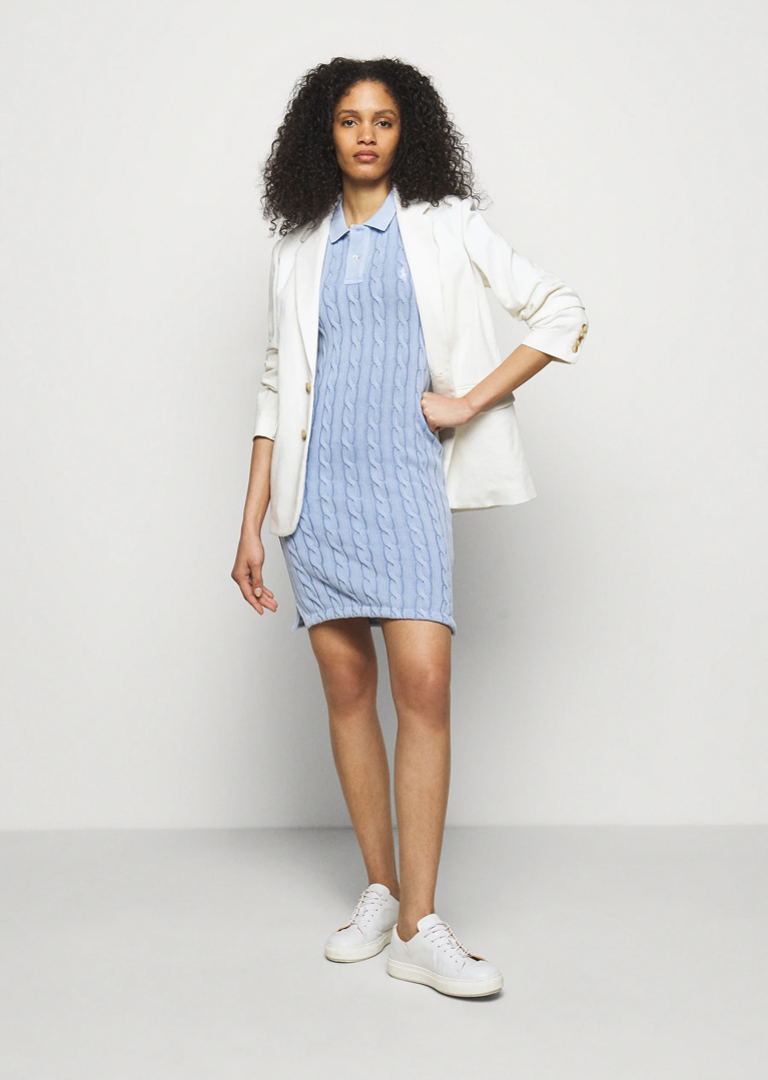

In [8]:
# Let's view sample images
images_list = sorted(Path(image_dir).glob("*.png"))

short_side = 768
image_path = images_list[-1]
img = Image.open(image_path).convert("RGB")
img = img.resize([short_side, int(short_side*img.size[1]/img.size[0])])
print(image_path.name, img.size)
display(img)

Let's benchmark the preprocessing and inference on CPU at full resolution

In [9]:
image_tensor = transform_rgb(img)
image_tensor = torch.unsqueeze(image_tensor, 0)
image_meta = [{
    'ori_shape':img.size,
    'img_shape':None,
    'pad_shape':None,
    'flip': False,
}]
output_arr = model([image_tensor], [image_meta], return_loss=False)[0]

In [10]:
output_arr.shape

(768, 1080)

In [104]:
%%timeit
image_tensor = transform_rgb(img)
image_tensor = torch.unsqueeze(image_tensor, 0)

12.1 ms ± 887 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [105]:
%%timeit
model([image_tensor], [image_meta], return_loss=False)

375 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


At 375 ms, the model is MUCH faster than U2NET. 

In [20]:
model = init_segmentor(config_file, "runs_3class_40k/latest.pth", device='cuda:0')
model.eval()
img2 = mmcv.imread(image_path)
result = inference_segmentor(model, img2)[0]

Use load_from_local loader


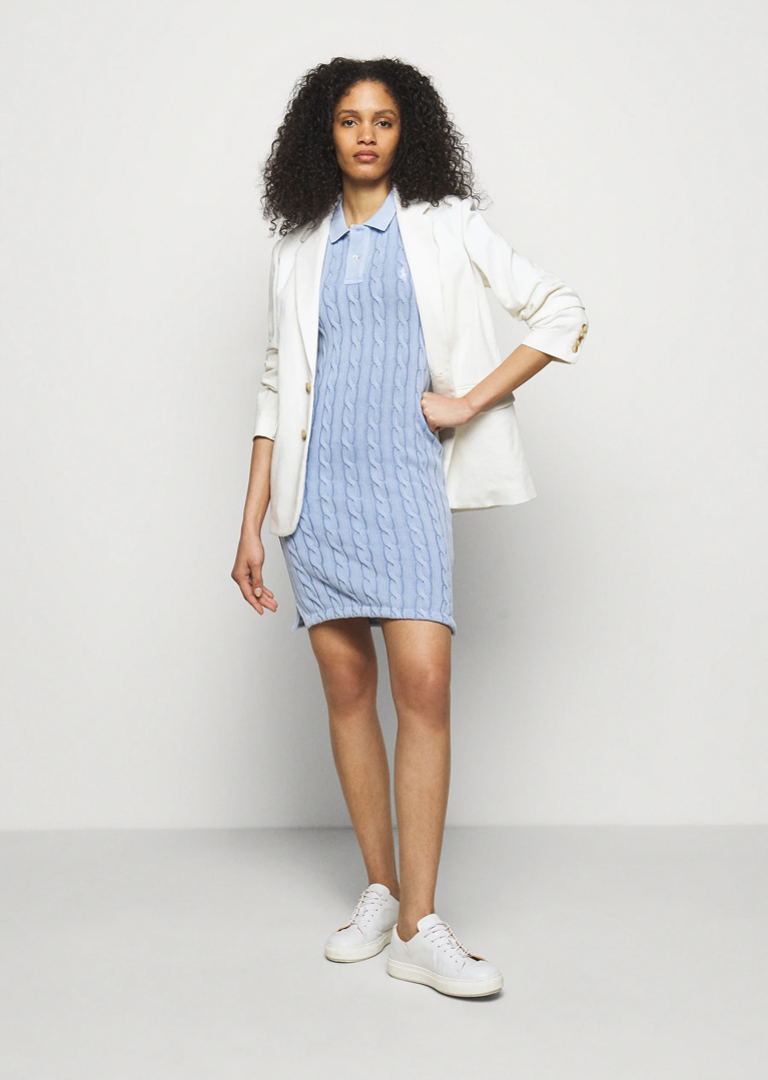

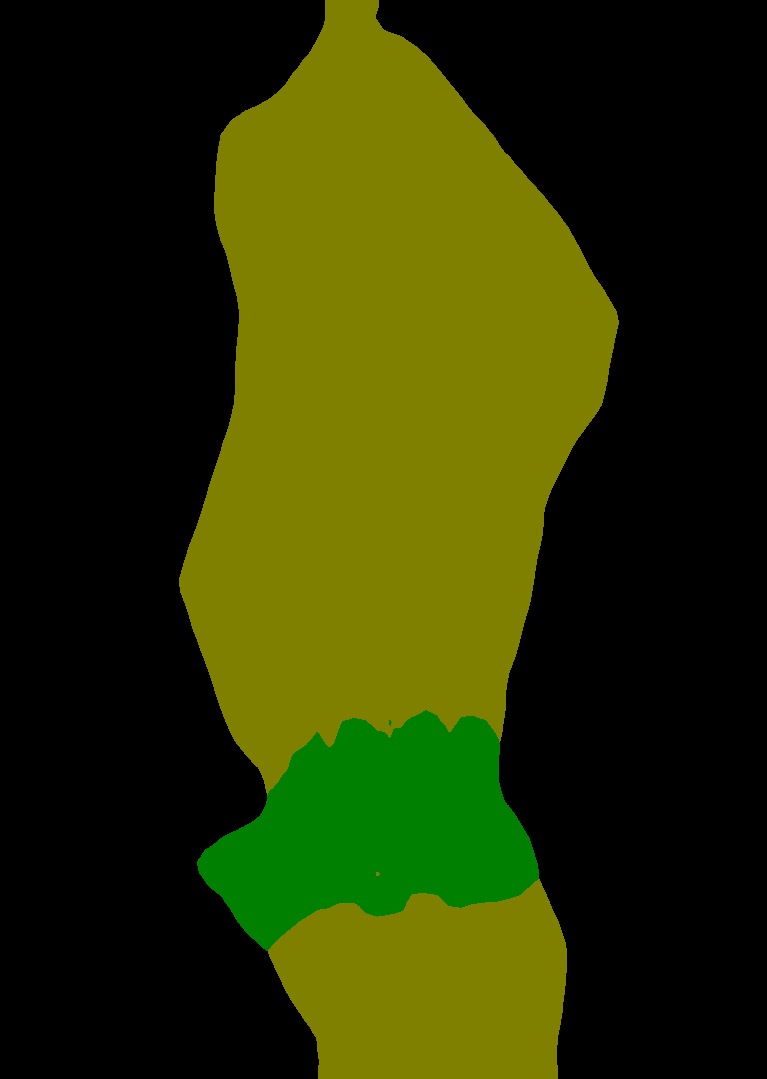

In [28]:
# Let's inspect the results
output_img = Image.fromarray(result.astype("uint8"), mode="L")
if do_palette:
    output_img.putpalette([0, 0, 0, 0, 128, 0, 128, 128, 0, 128, 0, 0, ])

display(img)
display(output_img)